In [53]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from sklearn.metrics import mean_squared_error
import xarray as xr

from salishsea_tools import viz_tools

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
tmask = mesh['tmask']
deptht = mesh['gdept_1d'][0]

In [3]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

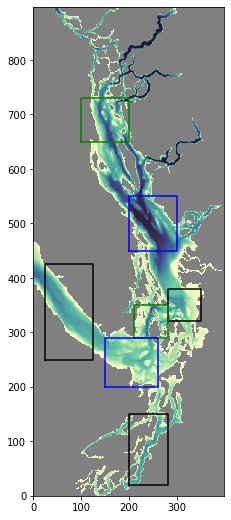

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);
SoG_center = [450, 550, 200, 300]
plot_box(ax, SoG_center, 'b')
SoG_north = [650, 730, 100, 200]
plot_box(ax, SoG_north, 'g')
SoG_south = [320, 380, 280, 350]
plot_box(ax, SoG_south, 'k')
Haro_Boundary = [290, 350, 210, 280]
plot_box(ax, Haro_Boundary, 'g')
JdF_east = [200, 290, 150, 260]
plot_box(ax, JdF_east, 'b')
JdF_west = [250, 425, 25, 125]
plot_box(ax, JdF_west, 'k')
PS_main = [20, 150, 200, 280]
plot_box(ax, PS_main, 'k')
SS_all = [0, 898, 0, 398]
boxes = [SS_all, SoG_south,SoG_center, SoG_north, PS_main, Haro_Boundary, JdF_west, JdF_east]
boxnames = ['SS_all', 'SoG_south', 'SoG_center', 'SoG_north', 'PS_main', 'Haro_Boundary',
           'JdF_west', 'JdF_east']

In [12]:
noy = 3
years = ['2007', '2008', '2009']
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [6]:
print (deptht[20])

<xarray.DataArray 'gdept_1d' ()>
array(24.100257)


In [7]:
def extract_phys(years, months, tdir, times_recon, temp_recon, dsal_recon):
    index = 0
    for year in years:
        for month in months:
            times_recon[index] = np.datetime64(f'{year}-{month}-15')
            try:
                filename = next(Path('/data/sallen/results/MEOPAR/202111/').glob(f'{tdir}/SalishSea_1m_{year}{month}_{year}{month}_grid_T.nc'))
            except:
                print (f'No file for {year} {month}')
            else:
                print (filename)
                grid_T = xr.open_dataset(filename)
                temp_recon[index] = np.ma.array(grid_T.votemper.isel(deptht=slice(0, 6), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, 6), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                dsal_recon[index] = (np.ma.array(grid_T.vosaline.isel(deptht=10, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=10, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                      - np.ma.array(grid_T.vosaline.isel(deptht=0, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=10, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean())
                grid_T.close()
            index = index + 1
    return times_recon, temp_recon, dsal_recon

In [8]:
def extract_par(years, months, tdir, par_recon):
    index = 0
    for year in years:
        for month in months:
            try:
                filename = next(Path('/data/sallen/results/MEOPAR/202111/').glob(f'{tdir}/SalishSea_1m_{year}{month}_{year}{month}_carp_T.nc'))
            except:
                print (f'No file for {year} {month}')
            else:
                print (filename)
                carp_T = xr.open_dataset(filename)
                par_recon[index] = np.ma.array(carp_T.PAR.isel(deptht=0, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=0, y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                carp_T.close()
            index = index + 1
    return par_recon

In [9]:
def extract_bio(years, months, tdir, diat_recon, flag_recon, nitrate_recon):
    dmax = 20
    imax = 19
    index = 0
    for year in years:
        for month in months:
            try:
                filename = next(Path('/data/sallen/results/MEOPAR/202111/').glob(f'{tdir}/SalishSea_1m_{year}{month}_{year}{month}_ptrc_T.nc'))
            except:
                print (f'No file for {year} {month}')
            else:
                print (filename)
                ptrc_T = xr.open_dataset(filename)
                diat_recon[index] = np.ma.array(ptrc_T.diatoms.sel(deptht=slice(0, dmax)).isel(y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, imax), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                flag_recon[index] = np.ma.array(ptrc_T.flagellates.sel(deptht=slice(0, dmax)).isel(y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, imax), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                nitrate_recon[index] = np.ma.array(ptrc_T.nitrate.sel(deptht=slice(0, 3)).isel(y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, 3), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                ptrc_T.close()
            index = index + 1
    return diat_recon, flag_recon, nitrate_recon
        

In [10]:
def extract_zoo(years, months, tdir, meso_recon, micro_recon):
    dmax = 20
    imax = 19
    index = 0
    for year in years:
        for month in months:
            try:
                filename = next(Path('/data/sallen/results/MEOPAR/202111/').glob(f'{tdir}/SalishSea_1m_{year}{month}_{year}{month}_ptrc_T.nc'))
            except:
                print (f'No file for {year} {month}')
            else:
                print (filename)
                ptrc_T = xr.open_dataset(filename)
                meso_recon[index] = np.ma.array(ptrc_T.mesozooplankton.sel(deptht=slice(0, dmax)).isel(y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, imax), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                micro_recon[index] = np.ma.array(ptrc_T.microzooplankton.sel(deptht=slice(0, dmax)).isel(y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3])), 
                                   mask=1-tmask[0].isel(z=slice(0, imax), y=slice(SoG_center[0], SoG_center[1]), 
                                                                    x=slice(SoG_center[2], SoG_center[3]))
                                  ).mean()
                ptrc_T.close()
            index = index + 1
    return meso_recon, micro_recon
        

In [13]:
times_recon = np.zeros(noy*12).astype('datetime64[s]')
temp_recon = np.zeros(noy*12)
dsal_recon = np.zeros_like(temp_recon)
diat_recon = np.zeros_like(temp_recon)
flag_recon = np.zeros_like(temp_recon)
nitrate_recon = np.zeros_like(temp_recon)
meso_recon = np.zeros_like(temp_recon)
micro_recon = np.zeros_like(temp_recon)
par_recon = np.zeros_like(temp_recon)
times_recon, temp_recon, dsal_recon = extract_phys(years, months, 'recon_datetime', times_recon, temp_recon, dsal_recon)
diat_recon, flag_recon, nitrate_recon = extract_bio(years, months, 'recon_datetime', diat_recon, flag_recon, nitrate_recon)
meso_recon, micro_recon = extract_zoo(years, months, 'recon_datetime', meso_recon, micro_recon)
par_recon = extract_par(years, months, 'recon_datetime', par_recon)

/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200705_200705_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200706_200706_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200707_200707_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200708_200708_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200709_200709_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200710_200710_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_datetime/SalishSea_1m_200711_200711_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_da

In [38]:
times_base = np.zeros(noy*12).astype('datetime64[s]')
temp_base = np.zeros(noy*12)
dsal_base = np.zeros_like(temp_base)
diat_base = np.zeros_like(temp_base)
flag_base = np.zeros_like(temp_base)
nitrate_base = np.zeros_like(temp_base)
meso_base = np.zeros_like(temp_base)
micro_base = np.zeros_like(temp_base)
par_base = np.zeros_like(temp_base)
times_base, temp_base, dsal_base = extract_phys(years, months, 'base_32/*/', times_base, temp_base, dsal_base)
diat_base, flag_base, nitrate_base = extract_bio(years, months, 'base_32/*/', diat_base, flag_base, nitrate_base)
meso_base, micro_base = extract_zoo(years, months, 'base_32/*/', meso_base, micro_base)
par_base = extract_par(years, months, 'base_32/*/', par_base)

/data/sallen/results/MEOPAR/202111/base_32/01jan07/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01feb07/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01feb07/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/23mar07/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01may07/SalishSea_1m_200705_200705_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01may07/SalishSea_1m_200706_200706_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01jul07/SalishSea_1m_200707_200707_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01jul07/SalishSea_1m_200708_200708_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01sep07/SalishSea_1m_200709_200709_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01sep07/SalishSea_1m_200710_200710_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_32/01nov07/SalishSea_1m_200711_200711_grid_T.nc
/data/sallen/results/MEOPAR/2021

In [15]:
times_opt = np.zeros(noy*12).astype('datetime64[s]')
temp_opt = np.zeros(noy*12)
dsal_opt = np.zeros_like(temp_opt)
diat_opt = np.zeros_like(temp_opt)
flag_opt = np.zeros_like(temp_opt)
nitrate_opt = np.zeros_like(temp_opt)
meso_opt = np.zeros_like(temp_opt)
micro_opt = np.zeros_like(temp_opt)
par_opt = np.zeros_like(temp_opt)
times_opt, temp_opt, dsal_opt = extract_phys(years, months, 'base_opt', times_opt, temp_opt, dsal_opt)
diat_opt, flag_opt, nitrate_opt = extract_bio(years, months, 'base_opt', diat_opt, flag_opt, nitrate_opt)
meso_opt, micro_opt = extract_zoo(years, months, 'base_opt', meso_opt, micro_opt)
par_opt = extract_par(years, months, 'base_opt', par_opt)

/data/sallen/results/MEOPAR/202111/base_opt/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_opt/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_opt/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_opt/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_opt/SalishSea_1m_200705_200705_grid_T.nc
/data/sallen/results/MEOPAR/202111/base_opt/SalishSea_1m_200706_200706_grid_T.nc
No file for 2007 07
No file for 2007 08
No file for 2007 09
No file for 2007 10
No file for 2007 11
No file for 2007 12
No file for 2008 01
No file for 2008 02
No file for 2008 03
No file for 2008 04
No file for 2008 05
No file for 2008 06
No file for 2008 07
No file for 2008 08
No file for 2008 09
No file for 2008 10
No file for 2008 11
No file for 2008 12
No file for 2009 01
No file for 2009 02
No file for 2009 03
No file for 2009 04
No file for 2009 05
No file for 2009 06
No file for 2009 07
No file for 20

In [ ]:
noy = 2
times_3havg = np.zeros(noy*12).astype('datetime64[s]')
temp_3havg = np.zeros(noy*12)
dsal_3havg = np.zeros_like(temp_3havg)
diat_3havg = np.zeros_like(temp_3havg)
flag_3havg = np.zeros_like(temp_3havg)
nitrate_3havg = np.zeros_like(temp_3havg)
meso_3havg = np.zeros_like(temp_3havg)
micro_3havg = np.zeros_like(temp_3havg)
par_3havg = np.zeros_like(temp_3havg)
times_3havg, temp_3havg, dsal_3havg = extract_phys(years, months, '3havg', times_3havg, 
                                                   temp_3havg, dsal_3havg)
diat_3havg, flag_3havg, nitrate_3havg = extract_bio(years, months, '3havg', diat_3havg, 
                                                    flag_3havg, nitrate_3havg)
meso_3havg, micro_3havg = extract_zoo(years, months, '3havg', meso_3havg, micro_3havg)
par_3havg = extract_par(years, months, '3havg', par_3havg)

In [ ]:
noy = 2
times_mixed = np.zeros(noy*12).astype('datetime64[s]')
temp_mixed = np.zeros(noy*12)
dsal_mixed = np.zeros_like(temp_mixed)
diat_mixed = np.zeros_like(temp_mixed)
flag_mixed = np.zeros_like(temp_mixed)
nitrate_mixed = np.zeros_like(temp_mixed)
meso_mixed = np.zeros_like(temp_mixed)
micro_mixed = np.zeros_like(temp_mixed)
par_mixed = np.zeros_like(temp_mixed)
times_mixed, temp_mixed, dsal_mixed = extract_phys(years, months, 'mixed_forcing', times_mixed, 
                                                   temp_mixed, dsal_mixed)
diat_mixed, flag_mixed, nitrate_mixed = extract_bio(years, months, 'mixed_forcing', diat_mixed, 
                                                    flag_mixed, nitrate_mixed)
meso_mixed, micro_mixed = extract_zoo(years, months, 'mixed_forcing', meso_mixed, micro_mixed)
par_mixed = extract_par(years, months, 'mixed_forcing', par_mixed)

In [ ]:
noy = 2
times_mixed2 = np.zeros(noy*12).astype('datetime64[s]')
temp_mixed2 = np.zeros(noy*12)
dsal_mixed2 = np.zeros_like(temp_mixed2)
diat_mixed2 = np.zeros_like(temp_mixed2)
flag_mixed2 = np.zeros_like(temp_mixed2)
nitrate_mixed2 = np.zeros_like(temp_mixed2)
meso_mixed2 = np.zeros_like(temp_mixed2)
micro_mixed2 = np.zeros_like(temp_mixed2)
par_mixed2 = np.zeros_like(temp_mixed2)
times_mixed2, temp_mixed2, dsal_mixed2 = extract_phys(years, months, 'mixed2', times_mixed2, 
                                                   temp_mixed2, dsal_mixed2)
diat_mixed2, flag_mixed2, nitrate_mixed2 = extract_bio(years, months, 'mixed2', diat_mixed2, 
                                                    flag_mixed2, nitrate_mixed2)
meso_mixed2, micro_mixed2 = extract_zoo(years, months, 'mixed2', meso_mixed2, micro_mixed2)
par_mixed2 = extract_par(years, months, 'mixed2', par_mixed2)

In [ ]:
noy = 2
times_mixed4 = np.zeros(noy*12).astype('datetime64[s]')
temp_mixed4 = np.zeros(noy*12)
dsal_mixed4 = np.zeros_like(temp_mixed4)
diat_mixed4 = np.zeros_like(temp_mixed4)
flag_mixed4 = np.zeros_like(temp_mixed4)
nitrate_mixed4 = np.zeros_like(temp_mixed4)
meso_mixed4 = np.zeros_like(temp_mixed4)
micro_mixed4 = np.zeros_like(temp_mixed4)
par_mixed4 = np.zeros_like(temp_mixed4)
times_mixed4, temp_mixed4, dsal_mixed4 = extract_phys(years, months, 'mixed4', times_mixed4, 
                                                   temp_mixed4, dsal_mixed4)
diat_mixed4, flag_mixed4, nitrate_mixed4 = extract_bio(years, months, 'mixed4', diat_mixed4, 
                                                    flag_mixed4, nitrate_mixed4)
meso_mixed4, micro_mixed4 = extract_zoo(years, months, 'mixed4', meso_mixed4, micro_mixed4)
par_mixed4 = extract_par(years, months, 'mixed4', par_mixed4)

In [ ]:
noy = 2
times_mixed5 = np.zeros(noy*12).astype('datetime64[s]')
temp_mixed5 = np.zeros(noy*12)
dsal_mixed5 = np.zeros_like(temp_mixed5)
diat_mixed5 = np.zeros_like(temp_mixed5)
flag_mixed5 = np.zeros_like(temp_mixed5)
nitrate_mixed5 = np.zeros_like(temp_mixed5)
meso_mixed5 = np.zeros_like(temp_mixed5)
micro_mixed5 = np.zeros_like(temp_mixed5)
par_mixed5 = np.zeros_like(temp_mixed5)
times_mixed5, temp_mixed5, dsal_mixed5 = extract_phys(years, months, 'badcubewinds', times_mixed5, 
                                                   temp_mixed5, dsal_mixed5)
diat_mixed5, flag_mixed5, nitrate_mixed5 = extract_bio(years, months, 'badcubewinds', diat_mixed5, 
                                                    flag_mixed5, nitrate_mixed5)
meso_mixed5, micro_mixed5 = extract_zoo(years, months, 'badcubewinds', meso_mixed5, micro_mixed5)
par_mixed5 = extract_par(years, months, 'badcubewinds', par_mixed5)

In [ ]:
noy = 2
times_mixed6 = np.zeros(noy*12).astype('datetime64[s]')
temp_mixed6 = np.zeros(noy*12)
dsal_mixed6 = np.zeros_like(temp_mixed6)
diat_mixed6 = np.zeros_like(temp_mixed6)
flag_mixed6 = np.zeros_like(temp_mixed6)
nitrate_mixed6 = np.zeros_like(temp_mixed6)
meso_mixed6 = np.zeros_like(temp_mixed6)
micro_mixed6 = np.zeros_like(temp_mixed6)
par_mixed6 = np.zeros_like(temp_mixed6)
times_mixed6, temp_mixed6, dsal_mixed6 = extract_phys(years, months, 'cubewinds', times_mixed6, 
                                                   temp_mixed6, dsal_mixed6)
diat_mixed6, flag_mixed6, nitrate_mixed6 = extract_bio(years, months, 'cubewinds', diat_mixed6, 
                                                    flag_mixed6, nitrate_mixed6)
meso_mixed6, micro_mixed6 = extract_zoo(years, months, 'cubewinds', meso_mixed6, micro_mixed6)
par_mixed6 = extract_par(years, months, 'cubewinds', par_mixed6)

In [16]:
times_reconX = np.zeros(noy*12).astype('datetime64[s]')
temp_reconX = np.zeros(noy*12)
dsal_reconX = np.zeros_like(temp_reconX)
diat_reconX = np.zeros_like(temp_reconX)
flag_reconX = np.zeros_like(temp_reconX)
nitrate_reconX = np.zeros_like(temp_reconX)
meso_reconX = np.zeros_like(temp_reconX)
micro_reconX = np.zeros_like(temp_reconX)
par_reconX = np.zeros_like(temp_reconX)
times_reconX, temp_reconX, dsal_reconX = extract_phys(years, months, 'reconX', times_reconX, temp_reconX, dsal_reconX)
diat_reconX, flag_reconX, nitrate_reconX = extract_bio(years, months, 'reconX', diat_reconX, flag_reconX, nitrate_reconX)
meso_reconX, micro_reconX = extract_zoo(years, months, 'reconX', meso_reconX, micro_reconX)
par_reconX = extract_par(years, months, 'reconX', par_reconX)

/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200705_200705_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200706_200706_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200707_200707_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200708_200708_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200709_200709_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200710_200710_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200711_200711_grid_T.nc
/data/sallen/results/MEOPAR/202111/reconX/SalishSea_1m_200712_200712_grid_T.nc
No file for 2008 01
No file for 2008 02
No file for 

In [ ]:
noy = 2
times_recon1 = np.zeros(noy*12).astype('datetime64[s]')
temp_recon1 = np.zeros(noy*12)
dsal_recon1 = np.zeros_like(temp_recon1)
diat_recon1 = np.zeros_like(temp_recon1)
flag_recon1 = np.zeros_like(temp_recon1)
nitrate_recon1 = np.zeros_like(temp_recon1)
meso_recon1 = np.zeros_like(temp_recon1)
micro_recon1 = np.zeros_like(temp_recon1)
par_recon1 = np.zeros_like(temp_recon1)
times_recon1, temp_recon1, dsal_recon1 = extract_phys(years, months, 'recon_absw', 
                                                      times_recon1, temp_recon1, dsal_recon1)
diat_recon1, flag_recon1, nitrate_recon1 = extract_bio(years, months, 'recon_absw', 
                                                       diat_recon1, flag_recon1, nitrate_recon1)
meso_recon1, micro_recon1 = extract_zoo(years, months, 'recon_absw', meso_recon1, micro_recon1)
par_recon1 = extract_par(years, months, 'recon_absw', par_recon1)
recon1_label = "Recon All but Solar & Winds"

In [ ]:
noy = 2
times_recon2 = np.zeros(noy*12).astype('datetime64[s]')
temp_recon2 = np.zeros(noy*12)
dsal_recon2 = np.zeros_like(temp_recon2)
diat_recon2 = np.zeros_like(temp_recon2)
flag_recon2 = np.zeros_like(temp_recon2)
nitrate_recon2 = np.zeros_like(temp_recon2)
meso_recon2 = np.zeros_like(temp_recon2)
micro_recon2 = np.zeros_like(temp_recon2)
par_recon2 = np.zeros_like(temp_recon2)
times_recon2, temp_recon2, dsal_recon2 = extract_phys(years, months, 'recon_abw', 
                                                      times_recon2, temp_recon2, dsal_recon2)
diat_recon2, flag_recon2, nitrate_recon2 = extract_bio(years, months, 'recon_abw', 
                                                       diat_recon2, flag_recon2, nitrate_recon2)
meso_recon2, micro_recon2 = extract_zoo(years, months, 'recon_abw', meso_recon2, micro_recon2)
par_recon2 = extract_par(years, months, 'recon_abw', par_recon2)
recon2_label = "Recon All but Winds"

In [17]:
times_recon3 = np.zeros(noy*12).astype('datetime64[s]')
temp_recon3 = np.zeros(noy*12)
dsal_recon3 = np.zeros_like(temp_recon3)
diat_recon3 = np.zeros_like(temp_recon3)
flag_recon3 = np.zeros_like(temp_recon3)
nitrate_recon3 = np.zeros_like(temp_recon3)
meso_recon3 = np.zeros_like(temp_recon3)
micro_recon3 = np.zeros_like(temp_recon3)
par_recon3 = np.zeros_like(temp_recon3)
times_recon3, temp_recon3, dsal_recon3 = extract_phys(years, months, 'recon_a', 
                                                      times_recon3, temp_recon3, dsal_recon3)
diat_recon3, flag_recon3, nitrate_recon3 = extract_bio(years, months, 'recon_a', 
                                                       diat_recon3, flag_recon3, nitrate_recon3)
meso_recon3, micro_recon3 = extract_zoo(years, months, 'recon_a', meso_recon3, micro_recon3)
par_recon3 = extract_par(years, months, 'recon_a', par_recon3)
recon3_label = "Recon All: Cube Winds"

/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200705_200705_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200706_200706_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200707_200707_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200708_200708_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200709_200709_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200710_200710_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200711_200711_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_a/SalishSea_1m_200712_200712_grid_T.nc
No file for 2008 01
No file for 2008 02


In [18]:
times_recon4 = np.zeros(noy*12).astype('datetime64[s]')
temp_recon4 = np.zeros(noy*12)
dsal_recon4 = np.zeros_like(temp_recon4)
diat_recon4 = np.zeros_like(temp_recon4)
flag_recon4 = np.zeros_like(temp_recon4)
nitrate_recon4 = np.zeros_like(temp_recon4)
meso_recon4 = np.zeros_like(temp_recon4)
micro_recon4 = np.zeros_like(temp_recon4)
par_recon4 = np.zeros_like(temp_recon4)
times_recon4, temp_recon4, dsal_recon4 = extract_phys(years, months, 'recon_b', 
                                                      times_recon4, temp_recon4, dsal_recon4)
diat_recon4, flag_recon4, nitrate_recon4 = extract_bio(years, months, 'recon_b', 
                                                       diat_recon4, flag_recon4, nitrate_recon4)
meso_recon4, micro_recon4 = extract_zoo(years, months, 'recon_b', meso_recon4, micro_recon4)
par_recon4 = extract_par(years, months, 'recon_b', par_recon4)
recon4_label = "Recon All: HF Winds"

/data/sallen/results/MEOPAR/202111/recon_b/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_b/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_b/SalishSea_1m_200703_200703_grid_T.nc
No file for 2007 04
No file for 2007 05
No file for 2007 06
No file for 2007 07
No file for 2007 08
No file for 2007 09
No file for 2007 10
No file for 2007 11
No file for 2007 12
No file for 2008 01
No file for 2008 02
No file for 2008 03
No file for 2008 04
No file for 2008 05
No file for 2008 06
No file for 2008 07
No file for 2008 08
No file for 2008 09
No file for 2008 10
No file for 2008 11
No file for 2008 12
No file for 2009 01
No file for 2009 02
No file for 2009 03
No file for 2009 04
No file for 2009 05
No file for 2009 06
No file for 2009 07
No file for 2009 08
No file for 2009 09
No file for 2009 10
No file for 2009 11
No file for 2009 12
/data/sallen/results/MEOPAR/202111/recon_b/SalishSea_1m_200701_200701_ptrc_T.nc
/data/sallen/results

In [57]:
times_recon5 = np.zeros(noy*12).astype('datetime64[s]')
temp_recon5 = np.zeros(noy*12)
dsal_recon5 = np.zeros_like(temp_recon5)
diat_recon5 = np.zeros_like(temp_recon5)
flag_recon5 = np.zeros_like(temp_recon5)
nitrate_recon5 = np.zeros_like(temp_recon5)
meso_recon5 = np.zeros_like(temp_recon5)
micro_recon5 = np.zeros_like(temp_recon5)
par_recon5 = np.zeros_like(temp_recon5)
times_recon5, temp_recon5, dsal_recon5 = extract_phys(years, months, 'recon_c', 
                                                      times_recon5, temp_recon5, dsal_recon5)
diat_recon5, flag_recon5, nitrate_recon5 = extract_bio(years, months, 'recon_c', 
                                                       diat_recon5, flag_recon5, nitrate_recon5)
meso_recon5, micro_recon5 = extract_zoo(years, months, 'recon_c', meso_recon5, micro_recon5)
par_recon5 = extract_par(years, months, 'recon_c', par_recon5)
recon5_label = "Recon All: X Winds"

/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200701_200701_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200702_200702_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200703_200703_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200704_200704_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200705_200705_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200706_200706_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200707_200707_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200708_200708_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200709_200709_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200710_200710_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200711_200711_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon_c/SalishSea_1m_200712_200712_grid_T.nc
/data/sallen/results/MEOPAR/202111/recon

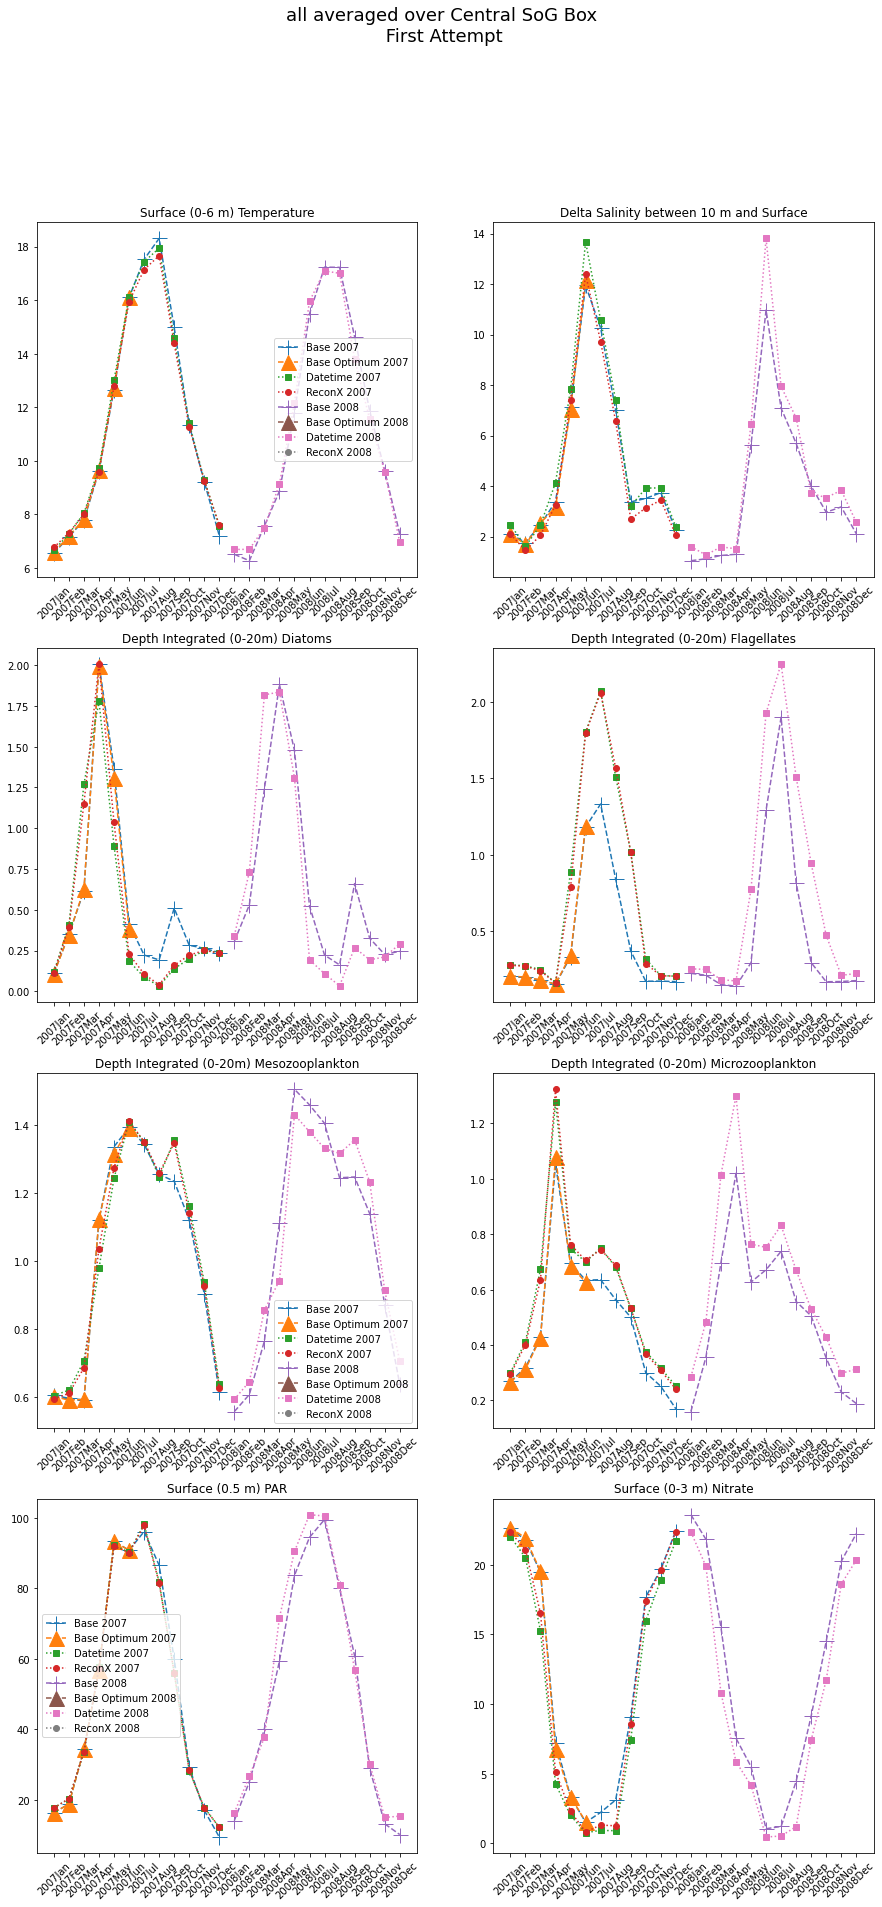

In [27]:
noy = 2
index = 14
times = times_base
fig, axs = plt.subplots(4, 2, figsize=(15, 30))
for iy in range(noy):
    lin, lup = iy*12, iy*12+12
    horz = [years[iy] + month_name[i%12] for i in range(lin, lup)]
    # Temperature
    vert = temp_base[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = temp_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = temp_3havg[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = temp_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 0].plot(horz, vert, '--*', label=f'Mixed Forcing {years[iy]}')
    vert = temp_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 0].plot(horz, vert, '-->', label=f'Mixed 2 {years[iy]}')
 #   vert = temp_mixed3[lin:lup]; vert[vert == 0] = np.nan
 #   axs[0, 0].plot(horz, vert, '--<', label=f'Mixed Flat Solar {years[iy]}')
    vert = temp_mixed4[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 0].plot(horz, vert, '--v', label=f'One hour from Three {years[iy]}')
    vert = temp_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 0].plot(horz, vert, '--<', label=f'Bad Cube winds {years[iy]}')
    vert = temp_mixed6[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 0].plot(horz, vert, '--d', label=f'Cube winds {years[iy]}')
    vert = temp_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 0].plot(horz, vert, '-D', label=f'{recon1_label} {years[iy]}')
    vert = temp_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 0].plot(horz, vert, '-P', label=f'{recon2_label} {years[iy]}')
    vert = temp_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}')
    vert = temp_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}')
    vert = temp_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}')
    # Stratification
    vert = dsal_base[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--+', markersize=15)
    vert = dsal_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--^', markersize=15)
    vert = dsal_3havg[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 1].plot(horz, vert, '--x')
    vert = dsal_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 1].plot(horz, vert, '--*')
    vert = dsal_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 1].plot(horz, vert, '-->')
 #   vert = dsal_mixed3[lin:lup]; vert[vert == 0] = np.nan
 #   axs[0, 1].plot(horz, vert, '--<')
    vert = dsal_mixed4[lin:lup]; vert[vert == 0] = np.nan
#    axs[0, 1].plot(horz, vert, '--v')
    vert = dsal_mixed5[lin:lup]; vert[vert == 0] = np.nan
 #   axs[0, 1].plot(horz, vert, '--<')
    vert = dsal_mixed6[lin:lup]; vert[vert == 0] = np.nan
 #   axs[0, 1].plot(horz, vert, '--d')
    vert = dsal_recon1[lin:lup]; vert[vert == 0] = np.nan
 #   axs[0, 1].plot(horz, vert, '-D')
    vert = dsal_recon2[lin:lup]; vert[vert == 0] = np.nan
 #   axs[0, 1].plot(horz, vert, '-P')
    vert = dsal_recon3[lin:lup]; vert[vert == 0] = np.nan
 #   axs[0, 1].plot(horz, vert, '-X')
    vert = dsal_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, ':s');
    vert = dsal_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, ':o');
    # Diatoms
    vert = diat_base[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = diat_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = diat_3havg[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = diat_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '--*', label=f'Mixed Forcing {years[iy]}')
    vert = diat_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '-->', label=f'Mixed 2 {years[iy]}')
  #  vert = diat_mixed3[lin:lup]; vert[vert == 0] = np.nan
  #  axs[1, 0].plot(horz, vert, '--<', label=f'Mixed flat Solar {years[iy]}')
    vert = diat_mixed4[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '--v', label=f'One hour from Three hour {years[iy]}')
    vert = diat_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '--<', label=f'Bad Cube Winds {years[iy]}')
    vert = diat_mixed6[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '--d', label=f'Cube Winds {years[iy]}')
    vert = diat_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '-D', label=f'{recon1_label} {years[iy]}')
    vert = diat_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '-P', label=f'{recon2_label} {years[iy]}')
    vert = diat_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}')
    vert = diat_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = diat_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');
    # Flagellates
    vert = flag_base[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--+', markersize=15)
    vert = flag_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--^', markersize=15)
    vert = flag_3havg[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '--x')
    vert = flag_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '--*')
    vert = flag_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '-->')
#    vert = flag_mixed3[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '--<')
    vert = flag_mixed4[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '--v')
    vert = flag_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '--<')
    vert = flag_mixed6[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '--d')
    vert = flag_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '-D')
    vert = flag_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '-P')
    vert = flag_recon3[lin:lup]; vert[vert == 0] = np.nan
 #   axs[1, 1].plot(horz, vert, '-X')
    vert = flag_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, ':s');
    vert = flag_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, ':o');
    # Mesozooplankton
    vert = meso_base[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = meso_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = meso_3havg[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = meso_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '--*', label=f'Mixed Forcing {years[iy]}')
    vert = meso_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '-->', label=f'Mixed 2 {years[iy]}')
#    vert = meso_mixed3[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '--<', label=f'Mixed flat Solar {years[iy]}')
    vert = meso_mixed4[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '--v', label=f'one hour from three hour {years[iy]}')
    vert = meso_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '--<', label=f'Bad Cube winds {years[iy]}')
    vert = meso_mixed6[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '--d', label=f'Cube winds {years[iy]}')
    vert = meso_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '-D', label=f'{recon1_label} {years[iy]}')
    vert = meso_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '-P', label=f'{recon2_label} {years[iy]}')
    vert = meso_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}')
    vert = meso_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = meso_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');
    # Microzooplankton
    vert = micro_base[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--+', markersize=15)
    vert = micro_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--^', markersize=15)
    vert = micro_3havg[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '--x', markersize=10)
    vert = micro_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '--*')
    vert = micro_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '-->')
#    vert = micro_mixed3[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '--<')
    vert = micro_mixed4[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '--v')
    vert = micro_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '-->')
    vert = micro_mixed6[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '--d')
    vert = micro_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '-D')
    vert = micro_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '-P')
    vert = micro_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '-X')
    vert = micro_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, ':s');
    vert = micro_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, ':o');
    # PAR
    vert = par_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = par_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = par_3havg[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = par_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '--*', label=f'Mixed forcing {years[iy]}')
    vert = par_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '-->', label=f'Mixed 2 forcing {years[iy]}')
 #   vert = par_mixed3[lin:lup]; vert[vert == 0] = np.nan
 #   axs[3, 0].plot(horz, vert, '--<', label=f'Mixed flat Solar {years[iy]}')
    vert = par_mixed4[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '--v', label=f'One hour from three hour {years[iy]}')
    vert = par_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '--<', label=f'Bad Cube winds {years[iy]}')
    vert = par_mixed6[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '--d', label=f'Cube winds {years[iy]}')
    vert = par_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '-D', label=f'{recon1_label} {years[iy]}')
    vert = par_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '-P', label=f'{recon2_label} {years[iy]}')
    vert = par_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}', markersize=20)
    vert = par_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = par_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');
    # Nitrate
    vert = nitrate_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = nitrate_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = nitrate_3havg[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = nitrate_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '--x', label=f'Mixed forcing {years[iy]}')
    vert = nitrate_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '-->', label=f'Mixed  2 forcing {years[iy]}')
  #  vert = nitrate_mixed3[lin:lup]; vert[vert == 0] = np.nan
  #  axs[3, 1].plot(horz, vert, '--<', label=f'Mixed flat Solar forcing {years[iy]}')
    vert = nitrate_mixed4[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '--v')
    vert = nitrate_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '-->')
    vert = nitrate_mixed6[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '--d')
    vert = nitrate_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '-D')
    vert = nitrate_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '-P')
    vert = nitrate_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '-X')
    vert = nitrate_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = nitrate_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');
#axs[3, 1].plot(times, np.cumsum(par_base), '--+')
#axs[3, 1].plot(times, np.cumsum(par_recon), '-x')
#axs[3, 1].plot(times, temp_recon/temp_base, '-s')
#ax2 = axs[3, 1].twinx()
#ax2.plot(times, np.cumsum(flag_base), 'g--+')
#ax2.plot(times, np.cumsum(flag_recon), 'r--+')
#ax2.plot(times, flag_recon/flag_base, '-or')
axs[0, 0].set_title('Surface (0-6 m) Temperature')
axs[0, 0].legend(loc='best')
axs[0, 1].set_title('Delta Salinity between 10 m and Surface')
axs[1, 0].set_title('Depth Integrated (0-20m) Diatoms')
#axs[1, 0].legend(loc='best')
axs[1, 1].set_title('Depth Integrated (0-20m) Flagellates');
axs[2, 0].set_title('Depth Integrated (0-20m) Mesozooplankton')
axs[2, 0].legend(loc='best')
axs[2, 1].set_title('Depth Integrated (0-20m) Microzooplankton');
axs[3, 0].set_title('Surface (0.5 m) PAR')
axs[3, 0].legend(loc='center left')
axs[3, 1].set_title('Surface (0-3 m) Nitrate')
#axs[3, 1].legend(loc='best')
for row in range(4):
    for ax in axs[row, :]:
        ax.tick_params(axis='x', labelrotation = 45)
fig.suptitle('all averaged over Central SoG Box\n First Attempt', fontsize=18);

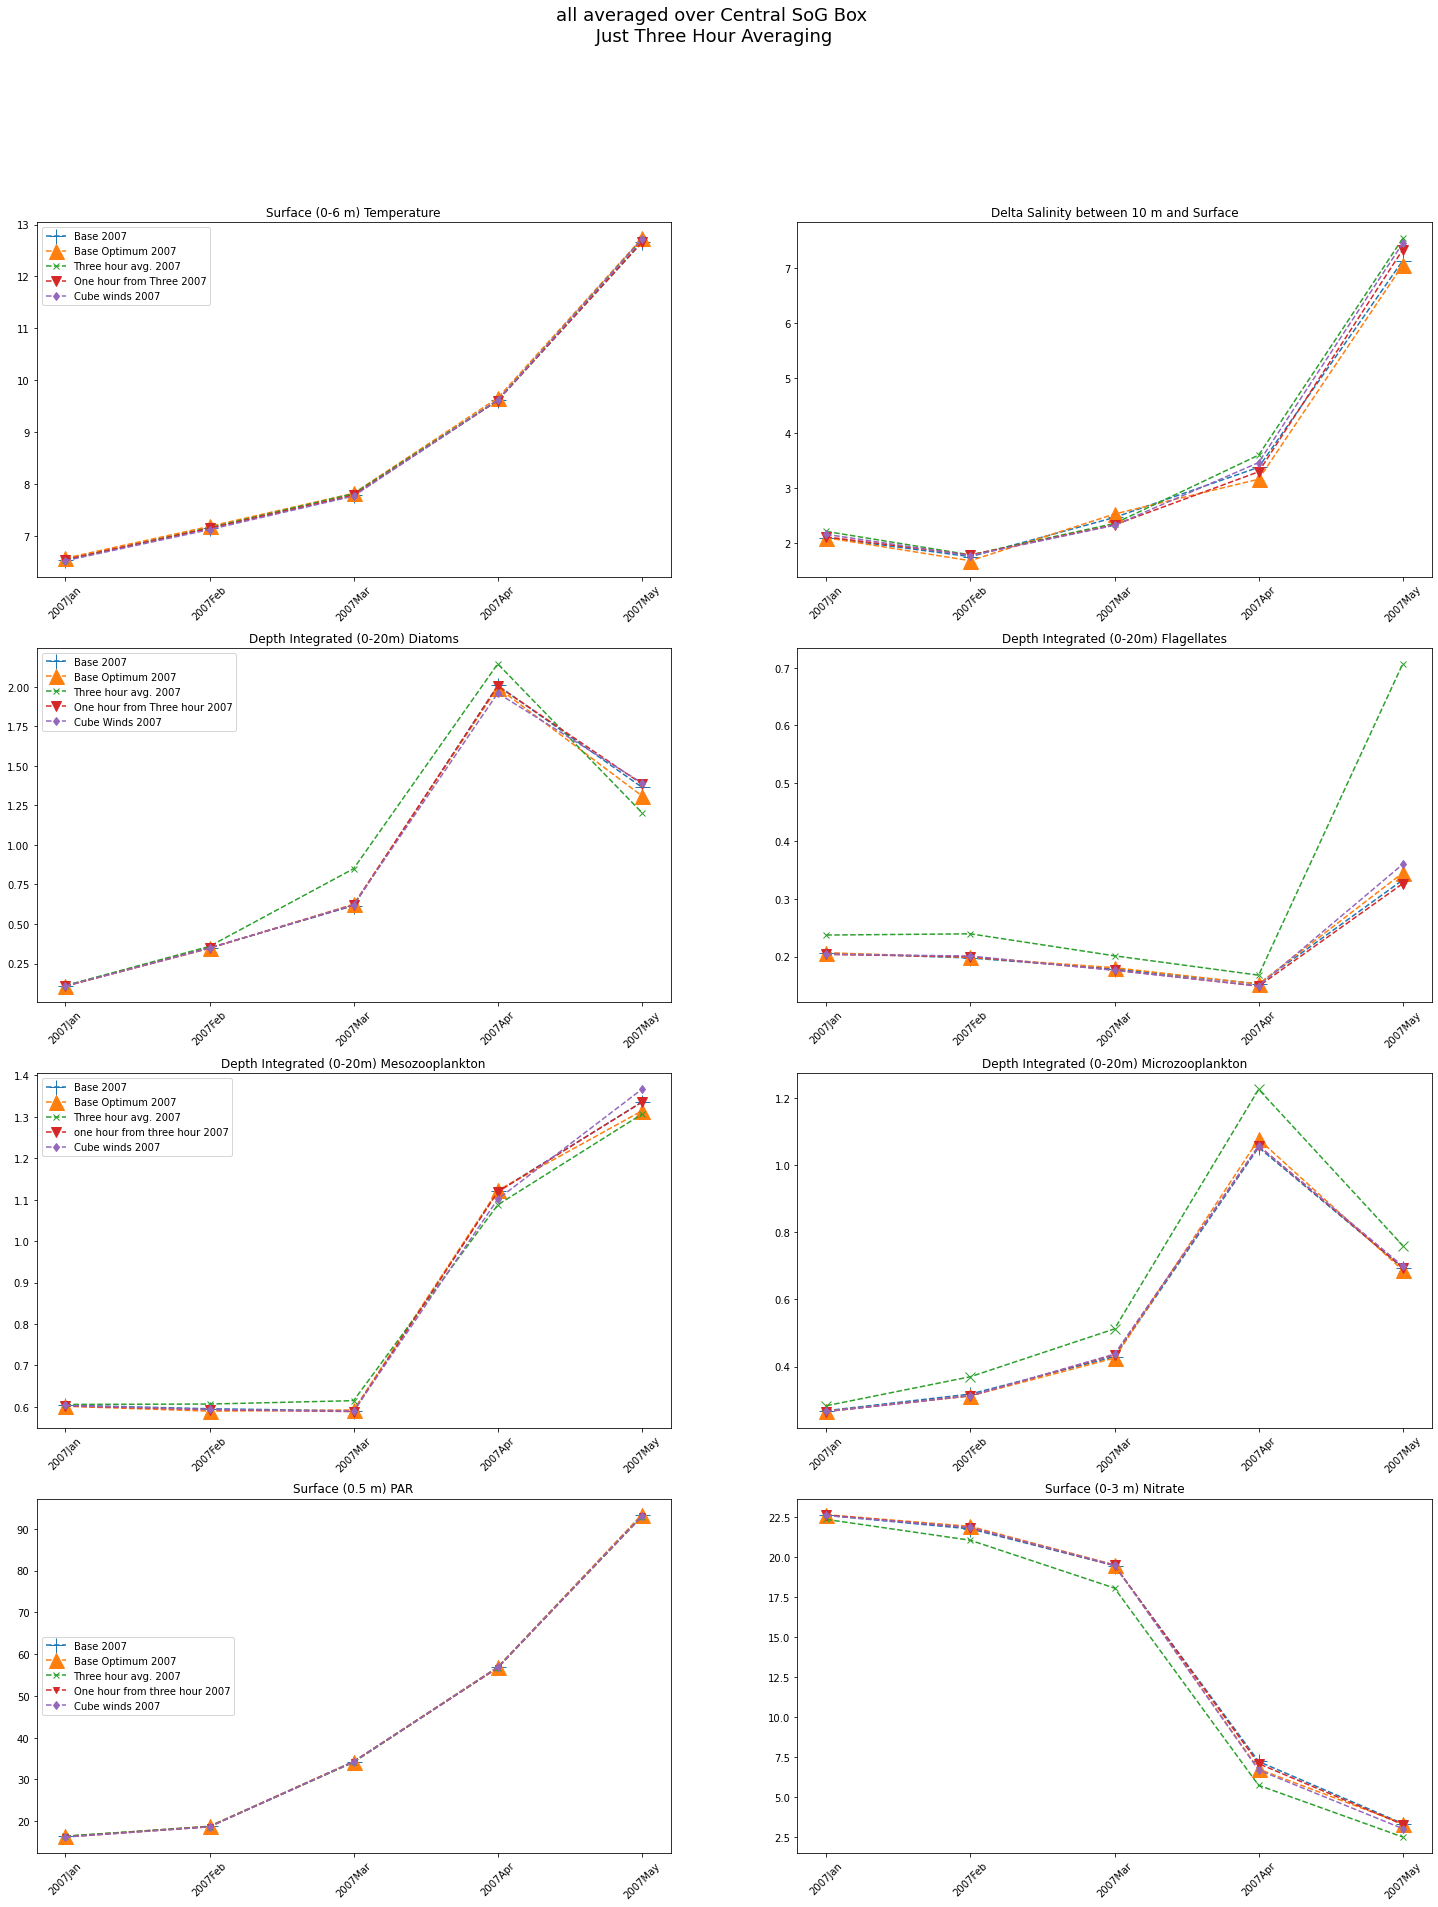

In [78]:
nnoy = 1
index = 14
times = times_base
fig, axs = plt.subplots(4, 2, figsize=(25, 30))
for iy in range(nnoy):
    lin, lup = iy*12, iy*12+5
    horz = [years[iy] + month_name[i%12] for i in range(lin, lup)]
    
    # Temperature
    vert = temp_base[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = temp_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = temp_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = temp_mixed4[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--v', label=f'One hour from Three {years[iy]}', markersize=10)
    vert = temp_mixed6[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--d', label=f'Cube winds {years[iy]}')

    # Stratification
    vert = dsal_base[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--+', markersize=15)
    vert = dsal_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--^', markersize=15)
    vert = dsal_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--x')
    vert = dsal_mixed4[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--v', markersize=10)
    vert = dsal_mixed6[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--d')
 
    # Diatoms
    vert = diat_base[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = diat_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = diat_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = diat_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '--*', label=f'Mixed Forcing {years[iy]}')
    vert = diat_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '-->', label=f'Mixed 2 {years[iy]}')
  #  vert = diat_mixed3[lin:lup]; vert[vert == 0] = np.nan
  #  axs[1, 0].plot(horz, vert, '--<', label=f'Mixed flat Solar {years[iy]}')
    vert = diat_mixed4[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--v', label=f'One hour from Three hour {years[iy]}', markersize=10)
    vert = diat_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '--<', label=f'Bad Cube Winds {years[iy]}')
    vert = diat_mixed6[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--d', label=f'Cube Winds {years[iy]}')
    vert = diat_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '-D', label=f'{recon1_label} {years[iy]}')
    vert = diat_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '-P', label=f'{recon2_label} {years[iy]}')
    vert = diat_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}')
    vert = diat_recon[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = diat_reconX[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');
    # Flagellates
    vert = flag_base[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--+', markersize=15)
    vert = flag_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--^', markersize=15)
    vert = flag_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--x')
    vert = flag_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '--*')
    vert = flag_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '-->')
#    vert = flag_mixed3[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '--<')
    vert = flag_mixed4[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--v', markersize=10)
    vert = flag_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '--<')
    vert = flag_mixed6[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--d')
    vert = flag_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '-D')
    vert = flag_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, '-P')
    vert = flag_recon3[lin:lup]; vert[vert == 0] = np.nan
 #   axs[1, 1].plot(horz, vert, '-X')
    vert = flag_recon[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, ':s');
    vert = flag_reconX[lin:lup]; vert[vert == 0] = np.nan
#    axs[1, 1].plot(horz, vert, ':o');
    # Mesozooplankton
    vert = meso_base[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = meso_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = meso_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = meso_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '--*', label=f'Mixed Forcing {years[iy]}')
    vert = meso_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '-->', label=f'Mixed 2 {years[iy]}')
#    vert = meso_mixed3[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '--<', label=f'Mixed flat Solar {years[iy]}')
    vert = meso_mixed4[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--v', label=f'one hour from three hour {years[iy]}', markersize=10)
    vert = meso_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '--<', label=f'Bad Cube winds {years[iy]}')
    vert = meso_mixed6[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--d', label=f'Cube winds {years[iy]}')
    vert = meso_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '-D', label=f'{recon1_label} {years[iy]}')
    vert = meso_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '-P', label=f'{recon2_label} {years[iy]}')
    vert = meso_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}')
    vert = meso_recon[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = meso_reconX[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');
    # Microzooplankton
    vert = micro_base[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--+', markersize=15)
    vert = micro_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--^', markersize=15)
    vert = micro_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--x', markersize=10)
    vert = micro_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '--*')
    vert = micro_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '-->')
#    vert = micro_mixed3[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '--<')
    vert = micro_mixed4[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--v', markersize=10)
    vert = micro_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '-->')
    vert = micro_mixed6[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--d')
    vert = micro_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '-D')
    vert = micro_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '-P')
    vert = micro_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, '-X')
    vert = micro_recon[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, ':s');
    vert = micro_reconX[lin:lup]; vert[vert == 0] = np.nan
#    axs[2, 1].plot(horz, vert, ':o');
    # PAR
    vert = par_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = par_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = par_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = par_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '--*', label=f'Mixed forcing {years[iy]}')
    vert = par_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '-->', label=f'Mixed 2 forcing {years[iy]}')
 #   vert = par_mixed3[lin:lup]; vert[vert == 0] = np.nan
 #   axs[3, 0].plot(horz, vert, '--<', label=f'Mixed flat Solar {years[iy]}')
    vert = par_mixed4[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--v', label=f'One hour from three hour {years[iy]}')
    vert = par_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '--<', label=f'Bad Cube winds {years[iy]}')
    vert = par_mixed6[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--d', label=f'Cube winds {years[iy]}')
    vert = par_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '-D', label=f'{recon1_label} {years[iy]}')
    vert = par_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '-P', label=f'{recon2_label} {years[iy]}')
    vert = par_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}', markersize=20)
    vert = par_recon[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = par_reconX[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');
    # Nitrate
    vert = nitrate_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = nitrate_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = nitrate_3havg[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--x', label=f'Three hour avg. {years[iy]}')
    vert = nitrate_mixed[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '--x', label=f'Mixed forcing {years[iy]}')
    vert = nitrate_mixed2[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '-->', label=f'Mixed  2 forcing {years[iy]}')
  #  vert = nitrate_mixed3[lin:lup]; vert[vert == 0] = np.nan
  #  axs[3, 1].plot(horz, vert, '--<', label=f'Mixed flat Solar forcing {years[iy]}')
    vert = nitrate_mixed4[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--v', markersize=10)
    vert = nitrate_mixed5[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '-->')
    vert = nitrate_mixed6[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--d')
    vert = nitrate_recon1[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '-D')
    vert = nitrate_recon2[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '-P')
    vert = nitrate_recon3[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, '-X')
    vert = nitrate_recon[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = nitrate_reconX[lin:lup]; vert[vert == 0] = np.nan
#    axs[3, 1].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');
#axs[3, 1].plot(times, np.cumsum(par_base), '--+')
#axs[3, 1].plot(times, np.cumsum(par_recon), '-x')
#axs[3, 1].plot(times, temp_recon/temp_base, '-s')
#ax2 = axs[3, 1].twinx()
#ax2.plot(times, np.cumsum(flag_base), 'g--+')
#ax2.plot(times, np.cumsum(flag_recon), 'r--+')
#ax2.plot(times, flag_recon/flag_base, '-or')
axs[0, 0].set_title('Surface (0-6 m) Temperature')
axs[0, 0].legend(loc='best')
axs[0, 1].set_title('Delta Salinity between 10 m and Surface')
axs[1, 0].set_title('Depth Integrated (0-20m) Diatoms')
axs[1, 0].legend(loc='best')
axs[1, 1].set_title('Depth Integrated (0-20m) Flagellates');
axs[2, 0].set_title('Depth Integrated (0-20m) Mesozooplankton')
axs[2, 0].legend(loc='best')
axs[2, 1].set_title('Depth Integrated (0-20m) Microzooplankton');
axs[3, 0].set_title('Surface (0.5 m) PAR')
axs[3, 0].legend(loc='center left')
axs[3, 1].set_title('Surface (0-3 m) Nitrate')
#axs[3, 1].legend(loc='best')
for row in range(4):
    for ax in axs[row, :]:
        ax.tick_params(axis='x', labelrotation = 45)
fig.suptitle('all averaged over Central SoG Box\n Just Three Hour Averaging', fontsize=18);

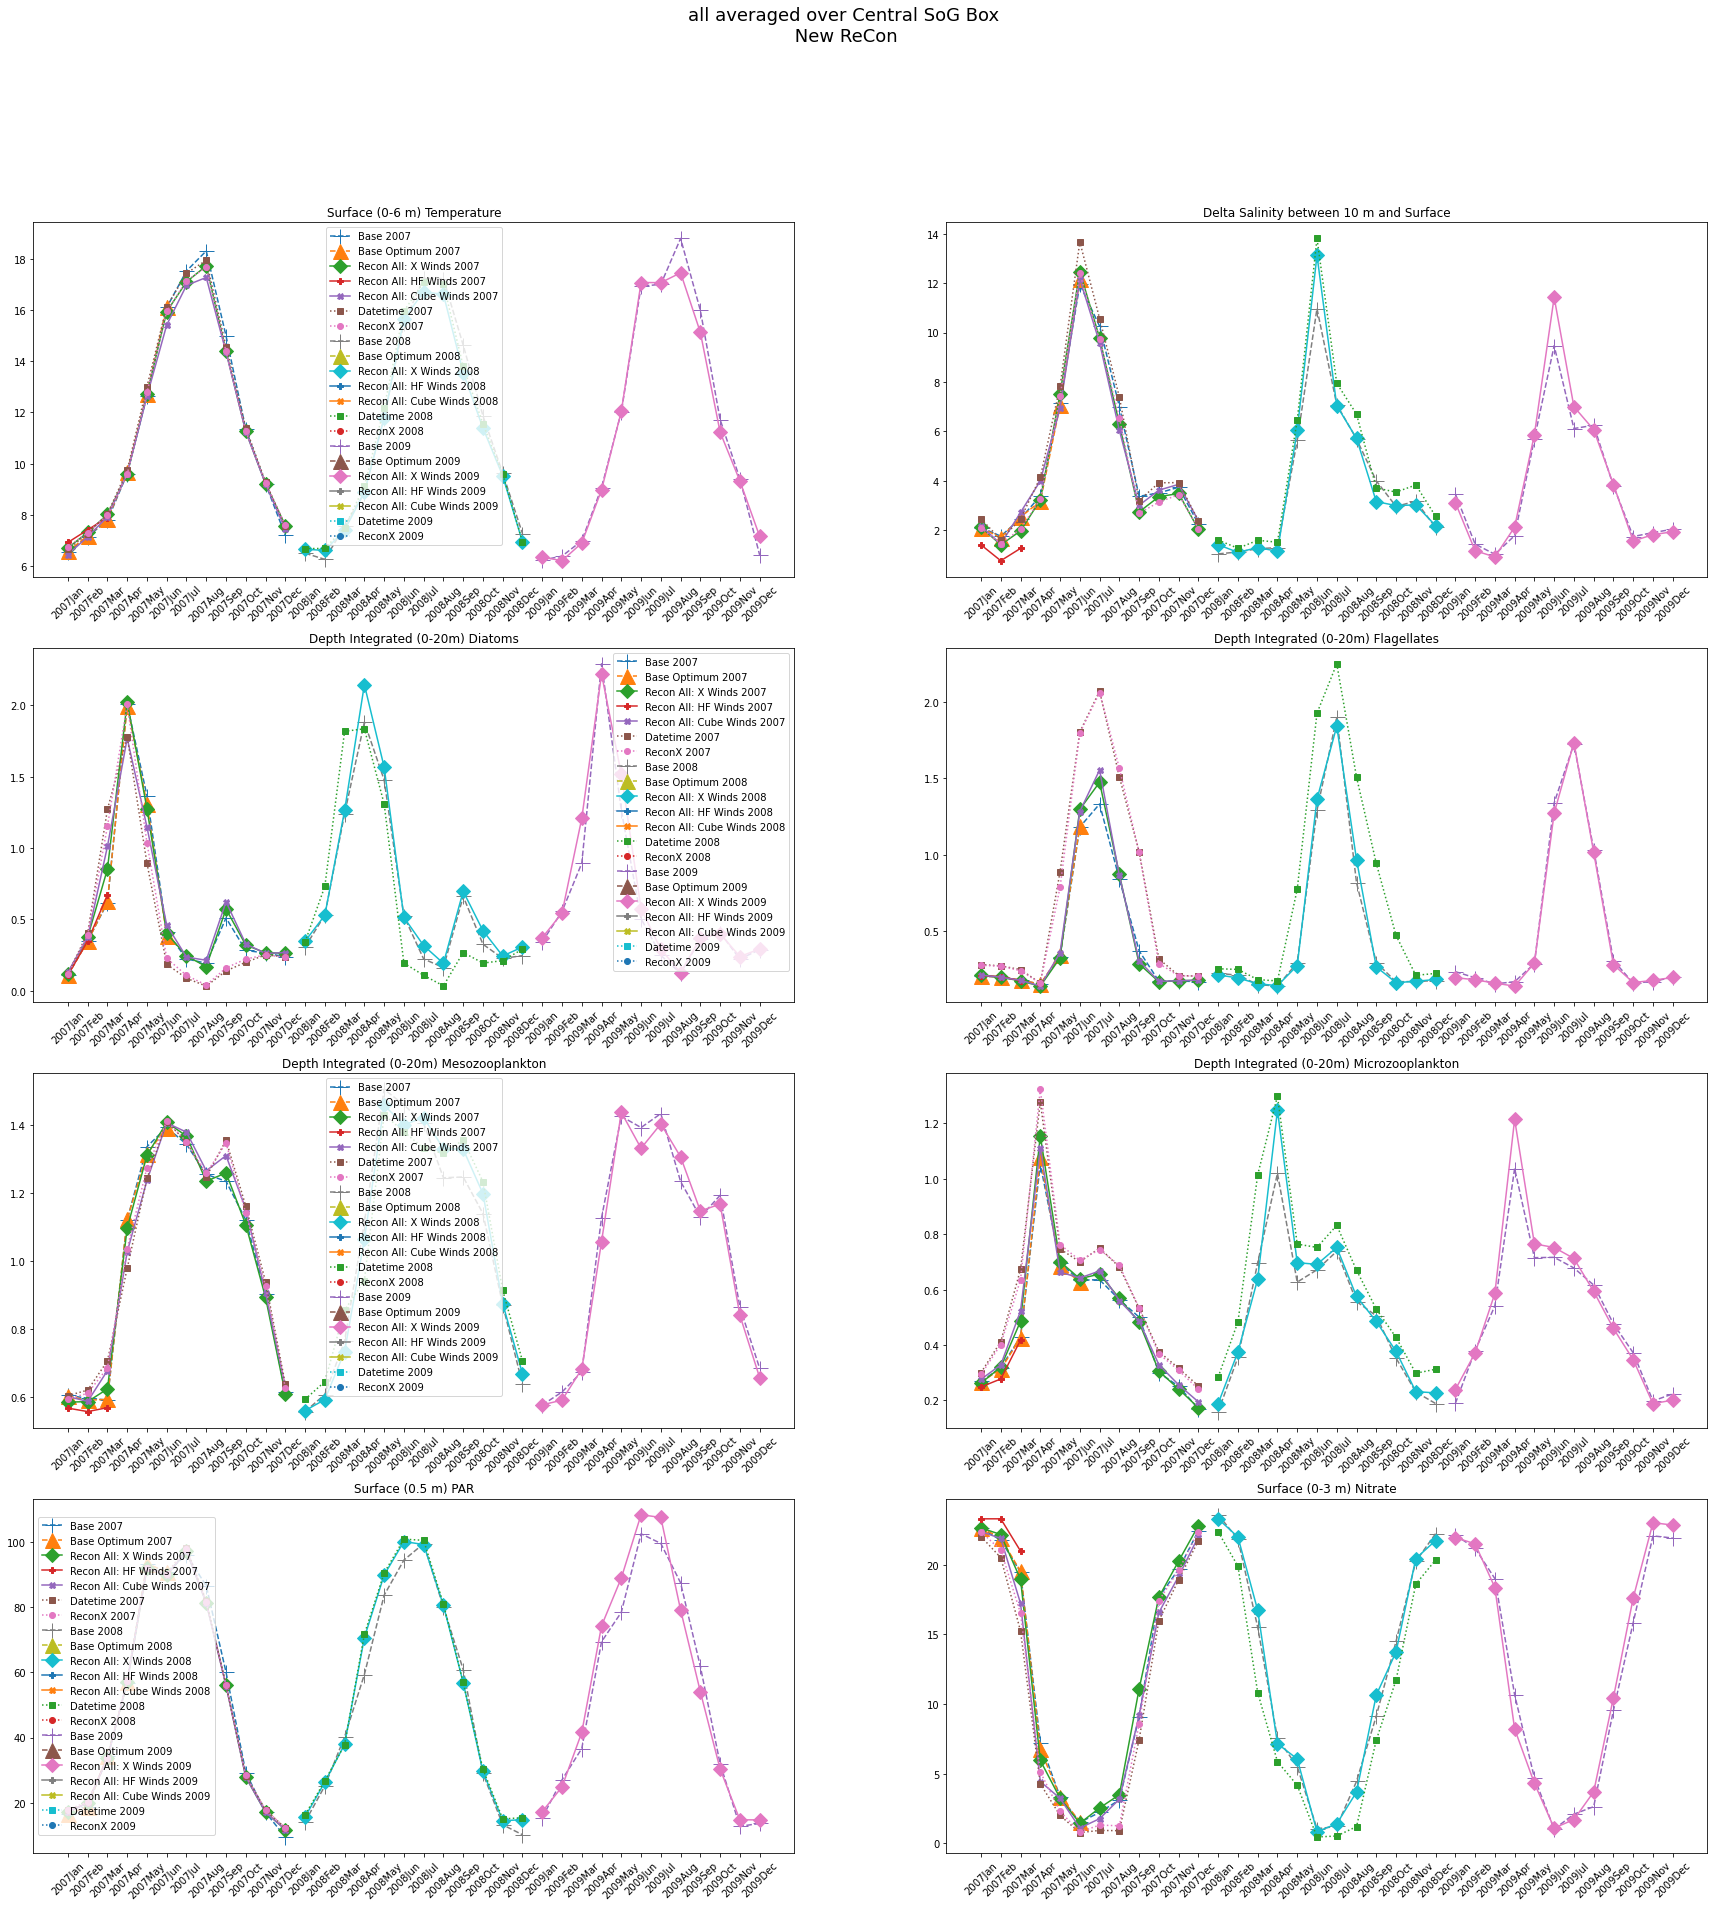

In [58]:
noy = 3
index = 14
times = times_base
fig, axs = plt.subplots(4, 2, figsize=(30, 30))
for iy in range(noy):
    lin, lup = iy*12, iy*12+12
    horz = [years[iy] + month_name[i%12] for i in range(lin, lup)]
    
    # Temperature
    vert = temp_base[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = temp_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = temp_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '-D', label=f'{recon5_label} {years[iy]}', markersize=10)
    vert = temp_recon4[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '-P', label=f'{recon4_label} {years[iy]}')
    vert = temp_recon3[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}')
    vert = temp_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}')
    vert = temp_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}')
    
    # Stratification
    vert = dsal_base[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--+', markersize=15)
    vert = dsal_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--^', markersize=15)
    vert = dsal_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '-D', markersize=10)
    vert = dsal_recon4[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '-P')
    vert = dsal_recon3[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '-X')
    vert = dsal_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, ':s');
    vert = dsal_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, ':o');
    
    # Diatoms
    vert = diat_base[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = diat_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = diat_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '-D', label=f'{recon5_label} {years[iy]}', markersize=10)
    vert = diat_recon4[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '-P', label=f'{recon4_label} {years[iy]}')
    vert = diat_recon3[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}')
    vert = diat_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = diat_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');
    
    # Flagellates
    vert = flag_base[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--+', markersize=15)
    vert = flag_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--^', markersize=15)
    vert = flag_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '-D', markersize=10)
    vert = flag_recon4[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '-P')
    vert = flag_recon3[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '-X')
    vert = flag_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, ':s');
    vert = flag_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, ':o');
    
    # Mesozooplankton
    vert = meso_base[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = meso_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = meso_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '-D', label=f'{recon5_label} {years[iy]}', markersize=10)
    vert = meso_recon4[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '-P', label=f'{recon4_label} {years[iy]}')
    vert = meso_recon3[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}')
    vert = meso_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = meso_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');

    # Microzooplankton
    vert = micro_base[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--+', markersize=15)
    vert = micro_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--^', markersize=15)
    vert = micro_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '-D', markersize=10)
    vert = micro_recon4[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '-P')
    vert = micro_recon3[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '-X')
    vert = micro_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, ':s');
    vert = micro_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, ':o');

    # PAR
    vert = par_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = par_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = par_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '-D', label=f'{recon5_label} {years[iy]}', markersize=10)
    vert = par_recon4[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '-P', label=f'{recon4_label} {years[iy]}')
    vert = par_recon3[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '-X', label=f'{recon3_label} {years[iy]}')
    vert = par_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = par_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');

    # Nitrate
    vert = nitrate_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15)
    vert = nitrate_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--^', label=f'Base Optimum {years[iy]}', markersize=15)
    vert = nitrate_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '-D', markersize=10)
    vert = nitrate_recon4[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '-P')
    vert = nitrate_recon3[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '-X')
    vert = nitrate_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, ':s', label=f'Datetime {years[iy]}');
    vert = nitrate_reconX[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, ':o', label=f'ReconX {years[iy]}');

axs[0, 0].set_title('Surface (0-6 m) Temperature')
axs[0, 0].legend(loc='upper center')
axs[0, 1].set_title('Delta Salinity between 10 m and Surface')
axs[1, 0].set_title('Depth Integrated (0-20m) Diatoms')
axs[1, 0].legend(loc='best')
axs[1, 1].set_title('Depth Integrated (0-20m) Flagellates');
axs[2, 0].set_title('Depth Integrated (0-20m) Mesozooplankton')
axs[2, 0].legend(loc='upper center')
axs[2, 1].set_title('Depth Integrated (0-20m) Microzooplankton');
axs[3, 0].set_title('Surface (0.5 m) PAR')
axs[3, 0].legend(loc='center left')
axs[3, 1].set_title('Surface (0-3 m) Nitrate')
#axs[3, 1].legend(loc='best')
for row in range(4):
    for ax in axs[row, :]:
        ax.tick_params(axis='x', labelrotation = 45)
fig.suptitle('all averaged over Central SoG Box\n New ReCon', fontsize=18);

### Interannual Comparison of Best ReCon and Base

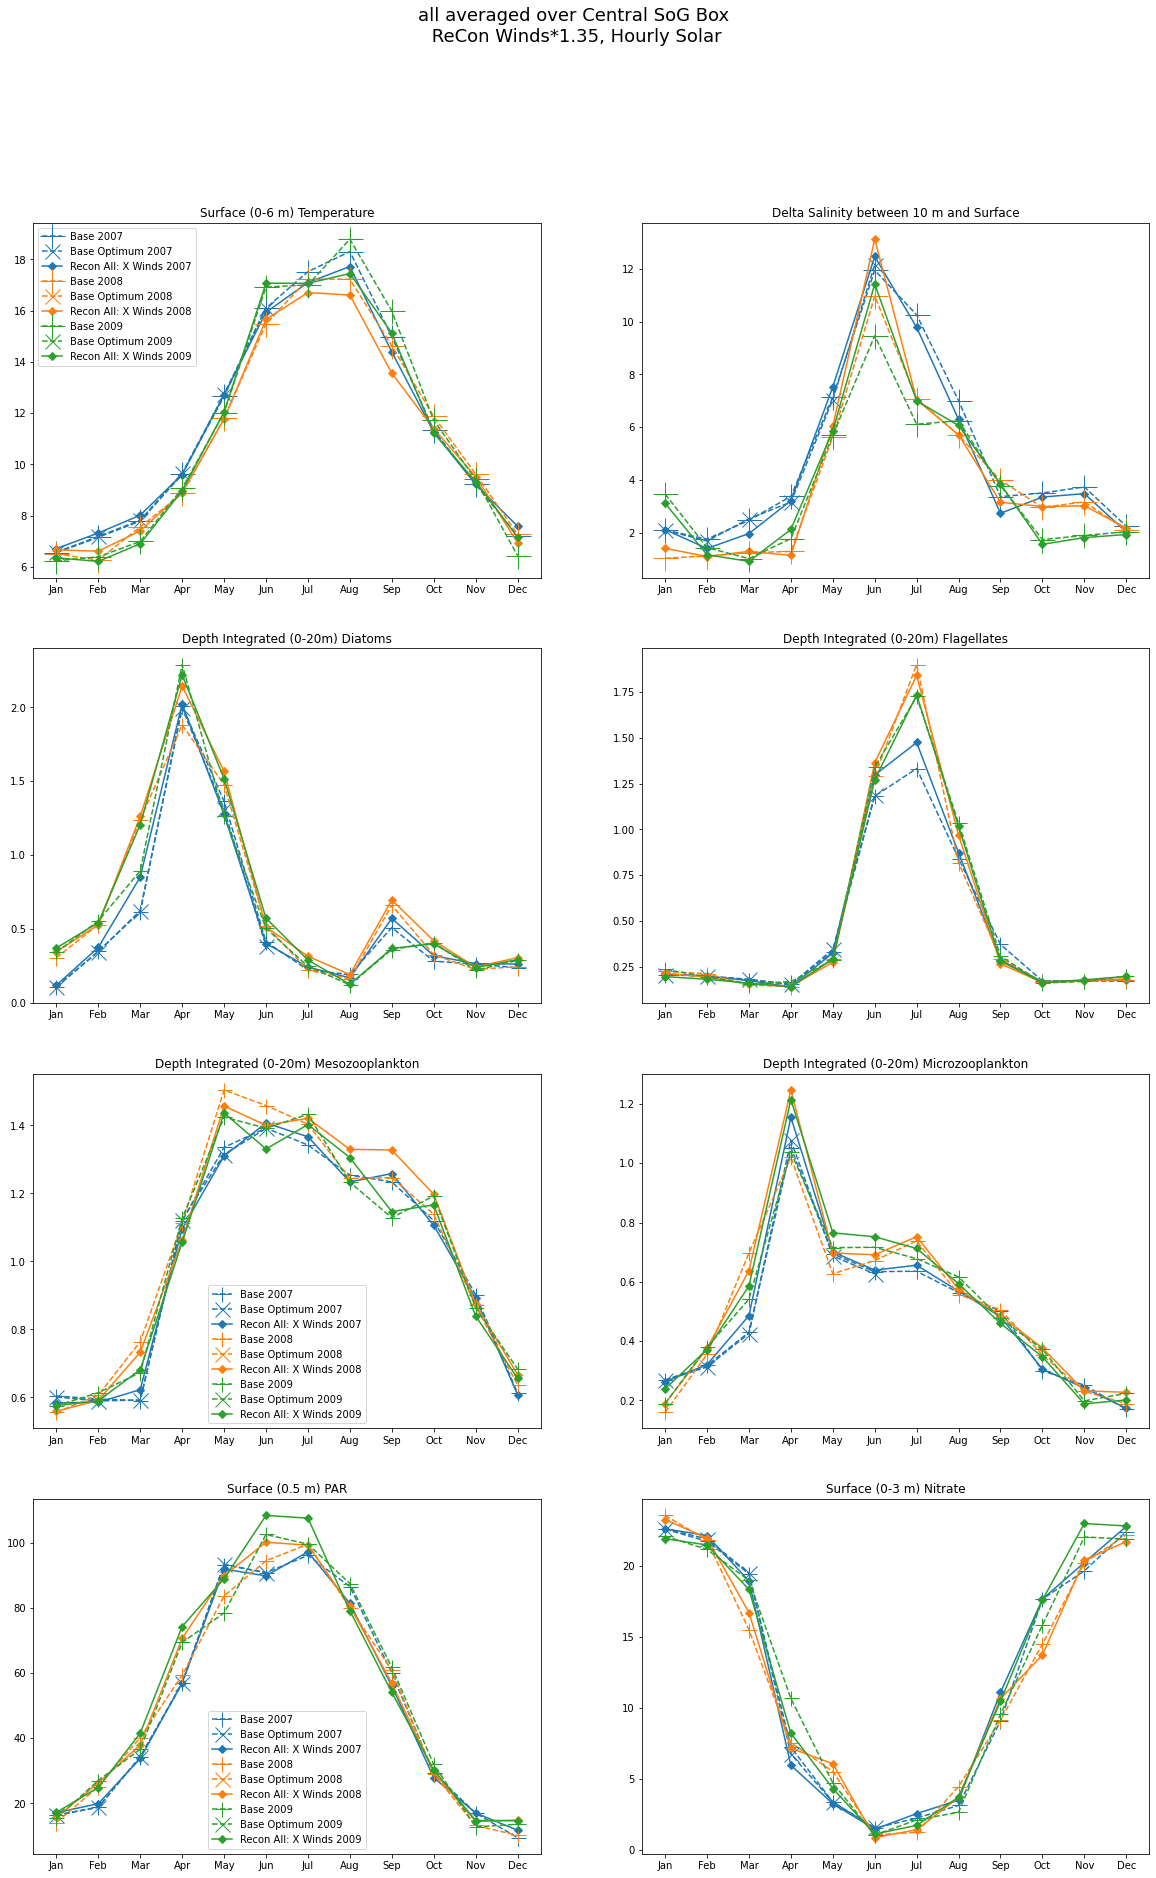

In [59]:
colours = ['tab:blue', 'tab:orange', 'tab:green']
noy = 3
index = 14
times = times_base
fig, axs = plt.subplots(4, 2, figsize=(20, 30))
for iy in range(noy):
    cc = colours[iy]
    lin, lup = iy*12, iy*12+12
    horz = [month_name[i%12] for i in range(lin, lup)]
    # Temperature
    vert = temp_base[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=25, c=cc)
    vert = temp_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '--x', label=f'Base Optimum {years[iy]}', markersize=15, c=cc)
    vert = temp_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert, '-D', label=f'{recon5_label} {years[iy]}', c=cc)
    
    # Stratification
    vert = dsal_base[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--+', markersize=25, c=cc)
    vert = dsal_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '--x', markersize=15, c=cc)
    vert = dsal_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert, '-D', c=cc)
  
    # Diatoms
    vert = diat_base[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15, c=cc)
    vert = diat_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '--x', label=f'Base Optimum {years[iy]}', markersize=15, c=cc)
    vert = diat_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert, '-D', label=f'{recon5_label} {years[iy]}', c=cc)
  
    # Flagellates
    vert = flag_base[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--+', markersize=15, c=cc)
    vert = flag_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '--x', markersize=15, c=cc)
    vert = flag_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert, '-D', c=cc)

    # Mesozooplankton
    vert = meso_base[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15, c=cc)
    vert = meso_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '--x', label=f'Base Optimum {years[iy]}', markersize=15, c=cc)
    vert = meso_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert, '-D', label=f'{recon5_label} {years[iy]}', c=cc)
 
    # Microzooplankton
    vert = micro_base[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--+', markersize=15, c=cc)
    vert = micro_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '--x', markersize=15, c=cc)
    vert = micro_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert, '-D', c=cc)

    # PAR
    vert = par_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--+', label=f'Base {years[iy]}', markersize=15, c=cc)
    vert = par_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '--x', label=f'Base Optimum {years[iy]}', markersize=15, c=cc)
    vert = par_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 0].plot(horz, vert, '-D', label=f'{recon5_label} {years[iy]}', c=cc)
   
    # Nitrate
    vert = nitrate_base[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--+', markersize=15, c=cc)
    vert = nitrate_opt[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '--x', markersize=15, c=cc)
    vert = nitrate_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert, '-D', c=cc)

axs[0, 0].set_title('Surface (0-6 m) Temperature')
axs[0, 0].legend(loc='best')
axs[0, 1].set_title('Delta Salinity between 10 m and Surface')
axs[1, 0].set_title('Depth Integrated (0-20m) Diatoms')
#axs[1, 0].legend(loc='best')
axs[1, 1].set_title('Depth Integrated (0-20m) Flagellates');
axs[2, 0].set_title('Depth Integrated (0-20m) Mesozooplankton')
axs[2, 0].legend(loc='best')
axs[2, 1].set_title('Depth Integrated (0-20m) Microzooplankton');
axs[3, 0].set_title('Surface (0.5 m) PAR')
axs[3, 0].legend(loc='lower center')
axs[3, 1].set_title('Surface (0-3 m) Nitrate')
fig.suptitle('all averaged over Central SoG Box\n ReCon Winds*1.35, Hourly Solar', fontsize=18);

In [74]:
print (np.nanmean(temp_base[:12]), np.nanmean(temp_base[12:24]), np.nanmean(temp_base[24:]))
print (np.nanmean(temp_recon5[:12]), np.nanmean(temp_recon5[12:24]), np.nanmean(temp_recon5[24:]))
print (np.nanmean(temp_opt[:6]) - np.nanmean(temp_base[:6]))
# Base: warm to cold: 2007, 2009, 2008
# Recon: warm to cold: 2007, 2009, 2008
# agree with Recon a bit cold

11.534040497308874 11.19285965189294 11.412595253460017
11.463692298714848 10.975807909526948 11.241566550417398
0.041220777497070316


In [75]:
print (np.nanmean(dsal_base[:12]), np.nanmean(dsal_base[12:24]), np.nanmean(dsal_base[24:]))
print (np.nanmean(dsal_recon5[:12]), np.nanmean(dsal_recon5[12:24]), np.nanmean(dsal_recon5[24:]))
print (np.nanmean(dsal_opt[:6]) - np.nanmean(dsal_base[:6]))
# Base: least to most stratified: 2009, 2008, 2007
# Recon: least to most stratified: 2009, 2008, 2007
# agree with Recon a bit stratified

4.910569118416366 3.860378301556031 3.7257607631004857
4.700520137683095 4.020452986565601 3.9045541786318503
-0.017098561117045996


In [76]:
print (np.nanmean(diat_base[:12]), np.nanmean(diat_base[12:24]), np.nanmean(diat_base[24:]))
print (np.nanmean(diat_recon5[:12]), np.nanmean(diat_recon5[12:24]), np.nanmean(diat_recon5[24:]))
print (np.nanmean(diat_opt[:6]) - np.nanmean(diat_base[:6]))
# Base: least to most diatoms: 2007, 2009, 2008
# Recon: least to most diatoms, 2007, 2008, 2009
# agree with Recon a bit more diatoms

0.5474578315249555 0.6500536690514696 0.6248597985295669
0.5733752912337986 0.7115146425780335 0.6791097817751547
-0.015573718223380606


In [77]:
print ('base, 2007', next((i, el) for i, el in enumerate(diat_base[:12]) if el > 1))
print ('base, 2008', next((i, el) for i, el in enumerate(diat_base[12:24]) if el > 1))
print ('base, 2009', next((i, el) for i, el in enumerate(diat_base[24:]) if el > 1))
print ('recon, 2007', next((i, el) for i, el in enumerate(diat_recon5[:12]) if el > 1))
print ('recon, 2008', next((i, el) for i, el in enumerate(diat_recon5[12:24]) if el > 1))
print ('recon, 2009', next((i, el) for i, el in enumerate(diat_recon5[24:]) if el > 1))
# Base: earliest to latest spring bloom: 2008, 2009, 2007
# Recon: earliest to latest spring bloom: 2008 and 2009 tied, 2007
# a bit of disagreement with 2009 bloom too early in 2009

base, 2007 (3, 2.0077760248207004)
base, 2008 (2, 1.2410699532414569)
base, 2009 (3, 2.2903090282660665)
recon, 2007 (3, 2.023510670088595)
recon, 2008 (2, 1.2628813414076783)
recon, 2009 (2, 1.2071037608986077)


In [78]:
print (np.nanmean(flag_base[:12]), np.nanmean(flag_base[12:24]), np.nanmean(flag_base[24:]))
print (np.nanmean(flag_recon5[:12]), np.nanmean(flag_recon5[12:24]), np.nanmean(flag_recon5[24:]))
print (np.nanmean(flag_opt[:6]) - np.nanmean(flag_base[:6]))
# Base: least to most flag: 2007, 2008, 2009
# Recon: least to most flag: 2007, 2009, 2008
# Disagree with 2008/2009 order but these are close values

0.4423450155074445 0.48639397876639184 0.4978500598672684
0.4581379178348978 0.49463629695996225 0.4839673115925152
0.0035072477939107616


In [80]:
print (np.nanmean(flag_base[5:8]), np.nanmean(flag_base[12+5:12+8]), np.nanmean(flag_base[24+5:24+8]))
print (np.nanmean(flag_recon5[5:8]), np.nanmean(flag_recon5[12+5:12+8]), np.nanmean(flag_recon5[24+5:24+8]))
# Same as above, 2008 and 2009 are close but switched in recon

1.118523183711855 1.3369770975425397 1.366817914147096
1.2149053659529836 1.3915296283926313 1.3411865932475509


Datetime 2007: 2.2089867288758827
Recon_C 2007: 2.161781691482882
Unweighted 2007: 7.5720949183037565
Datetime 2008: 5.032539349002925
Recon_C 2008: 4.544382781594548
Unweighted 2008: 5.94349483845177
Recon_C 2009: 5.790965511520249
Unweighted 2009: 5.3701244302669275


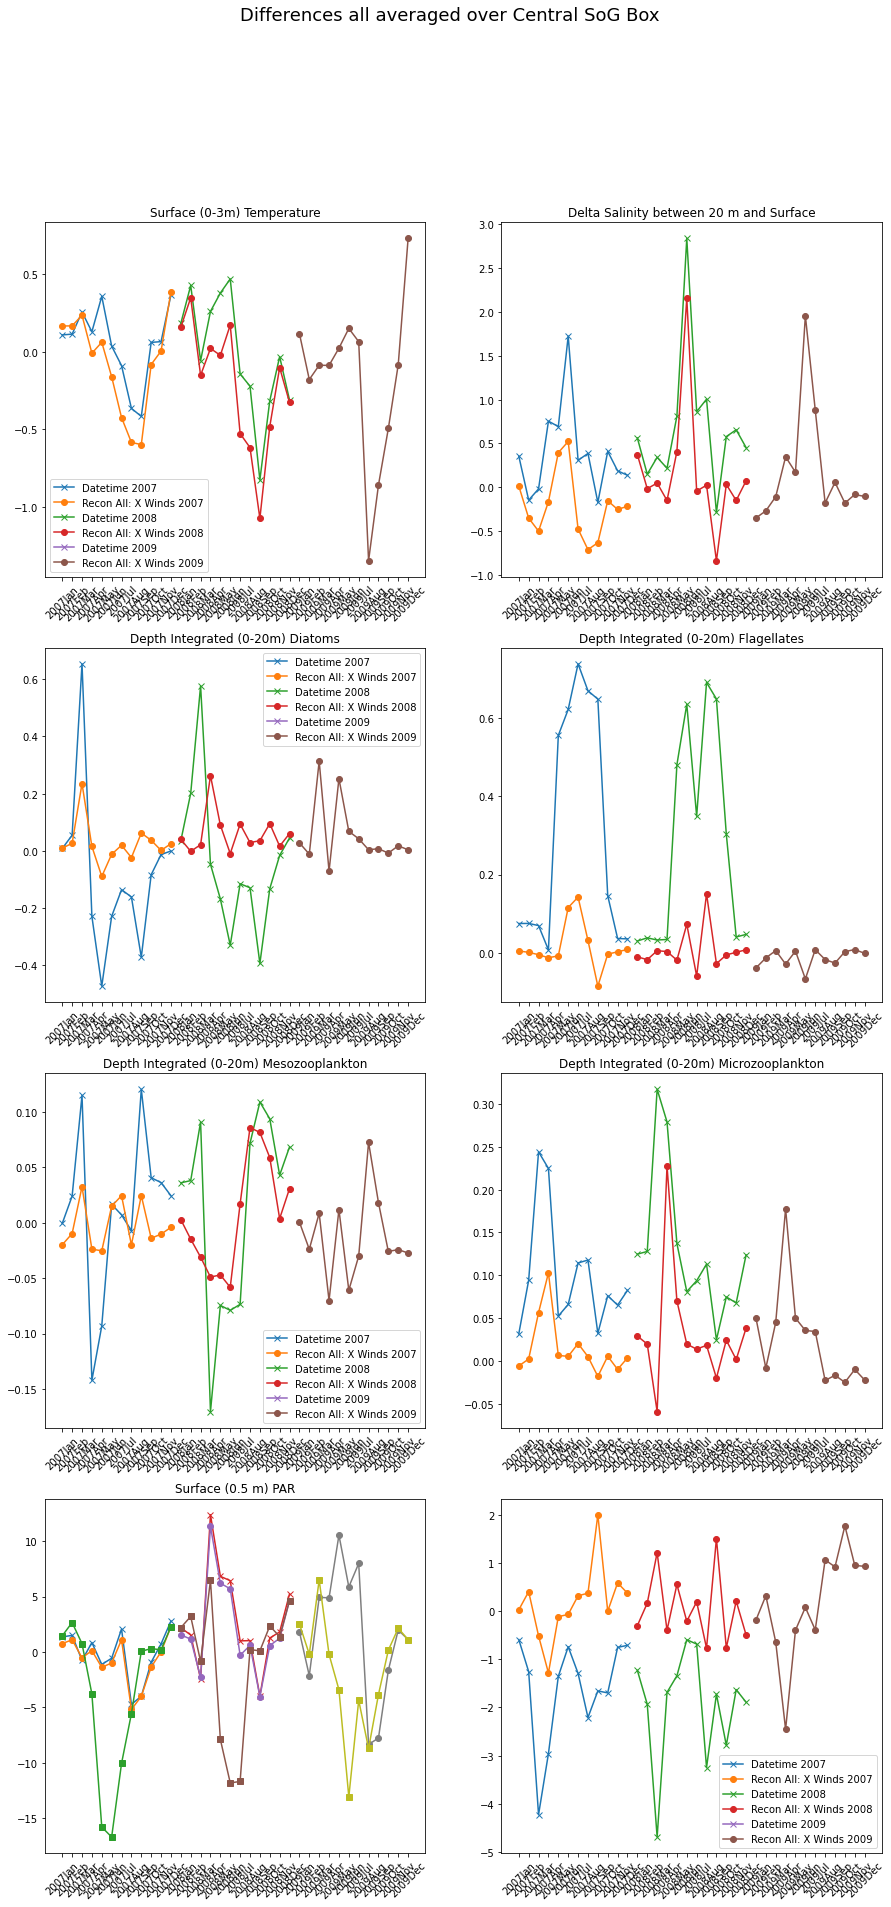

In [62]:
index = 14
times = times_base
fig, axs = plt.subplots(4, 2, figsize=(15, 30))
for iy in range(noy):
    lin, lup = iy*12, (iy+1)*12
    horz = [years[iy] + month_name[i%12] for i in range(lin, lup)]
    # Temperature
    vert1 = temp_base[lin:lup]; vert[vert == 0] = np.nan
    vert = temp_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert-vert1, '-x', label=f'Datetime {years[iy]}')
    vert = temp_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 0].plot(horz, vert-vert1, '-o', label=f'{recon5_label} {years[iy]}')
    # Stratification
    vert1 = dsal_base[lin:lup]; vert[vert == 0] = np.nan
    vert = dsal_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert-vert1, '-x');
    vert = dsal_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[0, 1].plot(horz, vert-vert1, '-o');
    # Diatoms
    vert1 = diat_base[lin:lup]; vert[vert == 0] = np.nan
    vert = diat_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert-vert1, '-x', label=f'Datetime {years[iy]}');
    vert = diat_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 0].plot(horz, vert-vert1, '-o', label=f'{recon5_label} {years[iy]}');
    # Flagellates
    vert1 = flag_base[lin:lup]; vert[vert == 0] = np.nan
    vert = flag_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert-vert1, '-x');
    vert = flag_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[1, 1].plot(horz, vert-vert1, '-o');
    # Mesozooplankton
    vert1 = meso_base[lin:lup]; vert[vert == 0] = np.nan
    vert = meso_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert-vert1, '-x', label=f'Datetime {years[iy]}');
    vert = meso_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 0].plot(horz, vert-vert1, '-o', label=f'{recon5_label} {years[iy]}');
    # Microzooplankton
    vert1 = micro_base[lin:lup]; vert[vert == 0] = np.nan
    vert = micro_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert-vert1, '-x');
    vert = micro_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[2, 1].plot(horz, vert-vert1, '-o');
    # PAR
    vert1 = par_base[lin:lup]; vert[vert == 0] = np.nan
    vert = par_recon[lin:lup]; vert[vert == 0] = np.nan
    if years[iy] != '2009':
        print (f'Datetime {years[iy]}: {mean_squared_error(vert1, vert, squared=False)}')
    axs[3, 0].plot(horz, vert-vert1, '-x', label=f'Datetime {years[iy]}');
    vert = par_recon5[lin:lup]; vert[vert == 0] = np.nan
    print (f'Recon_C {years[iy]}: {mean_squared_error(vert1, vert, squared=False)}')
    axs[3, 0].plot(horz, vert-vert1, '-o', label=f'{recon5_label} {years[iy]}');
    inv_solar_weight = 1 / np.array([0.96039022, 0.92770187, 0.96352634, 1.07366241, 1.18563039,
       1.21152227, 1.12943557, 1.00460236, 0.93242678, 0.94362803,
       0.98950765, 1.00023141])
    vert = par_recon5[lin:lup] * (inv_solar_weight); vert[vert == 0] = np.nan
    print (f'Unweighted {years[iy]}: {mean_squared_error(vert1, vert, squared=False)}')
    axs[3, 0].plot(horz, vert-vert1, '-s', label=f'Unweighted {recon5_label} {years[iy]}');
    # Nitrate
    vert1 = nitrate_base[lin:lup]; vert[vert == 0] = np.nan
    vert = nitrate_recon[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert-vert1, '-x', label=f'Datetime {years[iy]}');
    vert = nitrate_recon5[lin:lup]; vert[vert == 0] = np.nan
    axs[3, 1].plot(horz, vert-vert1, '-o', label=f'{recon5_label} {years[iy]}');
#axs[3, 1].plot(times, np.cumsum(par_base), '--+')
#axs[3, 1].plot(times, np.cumsum(par_recon), '-x')
#axs[3, 1].plot(times, temp_recon/temp_base, '-s')
#ax2 = axs[3, 1].twinx()
#ax2.plot(times, np.cumsum(flag_base), 'g--+')
#ax2.plot(times, np.cumsum(flag_recon), 'r--+')
#ax2.plot(times, flag_recon/flag_base, '-or')
axs[0, 0].set_title('Surface (0-3m) Temperature')
axs[0, 0].legend(loc='best')
axs[0, 1].set_title('Delta Salinity between 20 m and Surface')
axs[1, 0].set_title('Depth Integrated (0-20m) Diatoms')
axs[1, 0].legend(loc='best')
axs[1, 1].set_title('Depth Integrated (0-20m) Flagellates');
axs[2, 0].set_title('Depth Integrated (0-20m) Mesozooplankton')
axs[2, 0].legend(loc='best')
axs[2, 1].set_title('Depth Integrated (0-20m) Microzooplankton');
axs[3, 0].set_title('Surface (0.5 m) PAR')
axs[3, 1].legend(loc='best')
for row in range(4):
    for ax in axs[row, :]:
        ax.tick_params(axis='x', labelrotation = 45)
fig.suptitle('Differences all averaged over Central SoG Box', fontsize=18);

In [64]:
2.16 + 4.54 + 5.79

12.49

In [65]:
4.39 + 3.76 + 3.94

12.089999999999998

In [67]:
7.57 + 5.94 + 5.37

18.880000000000003

In [68]:
2.16 + 4.54

6.7

In [69]:
4.39 + 3.76

8.149999999999999

In [100]:
for alpha in np.arange(0, 1, 0.01):
    sumit = 0.
    for iy in range(0, 2):
        lin, lup = iy*12, (iy+1)*12
        vert1 = par_base[lin:lup]; vert[vert == 0] = np.nan
        vert2 = par_recon5[lin:lup]; vert[vert == 0] = np.nan
        solar_weight = np.array([0.96039022, 0.92770187, 0.96352634, 1.07366241, 1.18563039,
           1.21152227, 1.12943557, 1.00460236, 0.93242678, 0.94362803,
           0.98950765, 1.00023141])
        inv_solar_weight = 1./solar_weight
        vert = par_recon5[lin:lup] * inv_solar_weight * (1 + alpha * (solar_weight - 1)); vert[vert == 0] = np.nan
        sumit = sumit + mean_squared_error(vert1, vert, squared=False)
    print (alpha, sumit)

0.0 13.515589756755526
0.01 13.386795230592936
0.02 13.258415592875817
0.03 13.130463567475456
0.04 13.002952329943385
0.05 12.875895523165035
0.06 12.74930727331829
0.07 12.623202206107091
0.08 12.497595463234493
0.09 12.372502719073239
0.1 12.247940197484798
0.11 12.12392468873028
0.12 12.000473566408047
0.13 11.877604804344005
0.14 11.75533699335028
0.15 11.633689357757863
0.16 11.512681771616819
0.17 11.392334774446335
0.18 11.272669586403225
0.19 11.153708122724916
0.2 11.035473007288527
0.21 10.917987585113302
0.22 10.801275933619552
0.23 10.685362872441981
0.24 10.57027397158124
0.25 10.456035557663496
0.26 10.342674718064497
0.27 10.230219302643032
0.28 10.118697922818173
0.29 10.008139947716838
0.3 9.898575497113473
0.31 9.790035430881279
0.32 9.682551334678045
0.33 9.576155501596393
0.34 9.470880909522158
0.35000000000000003 9.366761193964567
0.36 9.263830616149034
0.37 9.162124026199486
0.38 9.061676821280962
0.39 8.962524898627729
0.4 8.864704603445718
0.41000000000000003 8

In [101]:
(0.63*2+1)/3.

0.7533333333333333